# TO DO List
1. Get the 'Average customer ratings' for comfort, cleanliness, location, quality
1. Do a scatter plot of distance from sydney vs bookings count???
1. Distance vs revenue?
1. Distance vs revenue per person (assuming full occupancy)
1. Percentage occupancy for the month vs distance
1. 30/60/90 day occupancy vs distance (forward bookings)
1. Last 30/60/90 day actual occupance vs distance (history bookings)
1. Count how many places have zero bookings

In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
date_str = datetime.datetime.now().strftime("%Y-%m-%d")

print("Date: " + date_str)

Date: 2018-04-12


Dataset 1 - Load the nsw_extract daily file. This starts with the https://www.stayz.com.au/accommodation/nsw page and then follows the link to each propert. This is the quick (30 minutes) extract of raw details, as it excludes the calendar details.

In [3]:
# Read the data file and display
nsw_extract_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json')

# Reindex for 'property_id'
nsw_extract_2 = nsw_extract_1.set_index('property_id')

nsw_extract_3 = nsw_extract_2.sort_index()

nsw_extract = nsw_extract_3


print("nsw_extract index: " + str(nsw_extract.index.dtype_str))

nsw_extract.head()

nsw_extract index: int64


,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,,
806,3,3,5,"[<p><center>, </p>, ELEGANTLY 5 STAR As seen ...",346,8,'T A M B A C' Your Ultimate Beach House Experi...,408,-32.33650,152.54400,House,6,2018-04-12 01:14:42,NE,35,223,https://www.stayz.com.au//accommodation/nsw/no...
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.06640,150.67400,Cottage,29,2018-04-12 01:06:53,S,201,128,https://www.stayz.com.au//accommodation/nsw/so...
1971,3,6,11,[Ski Cove House is a two storey waterfront on ...,480,15,Ski Cove House with perfect sunsets,357,-32.38740,152.50100,House,56,2018-04-12 01:04:52,NE,34,216,https://www.stayz.com.au//accommodation/nsw/no...
2040,2,3,6,[Walking down the driveway that enjoys views t...,270,6,Beaches Mollymook a Beaches&Mntns Girls Getawa...,403,-35.32348,150.48463,House,0,2018-04-12 01:08:07,SW,203,161,https://www.stayz.com.au//accommodation/nsw/so...
2042,4,5,11,"[Lavender Manor is a very spacious, gorgeously...",296,15,"Lavender Manor, Blackheath",505,-33.64980,150.29800,Cottage,6,2018-04-12 01:07:26,NW,294,89,https://www.stayz.com.au//accommodation/nsw/bl...


Dataset 2 - Load the full geocoded address file. This is the Google reverse geocoder API output for each of the latitude/longitude details for each property. Note that the street number is not exact for the property but is within a few houses and is the same street. Stayz deliberatly obfuscates the exact location however all other details are correct apart from house number.

In [4]:
# Read the data file and display
geodata_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_full.json')

geodata_2 = geodata_1.set_index('property_id')
geodata_3 = geodata_2.sort_index()

geodata = geodata_3


print("geodata index: " + str(geodata.index.dtype_str))

geodata.head(10)

geodata index: int64


,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,
52,Gosford,"24 Avoca Dr, Avoca Beach NSW 2251, Australia",2251,Avoca Dr,24,NSW,Avoca Beach
717,Pittwater,"342 Whale Beach Rd, Palm Beach NSW 2108, Austr...",2108,Whale Beach Rd,342,NSW,Palm Beach
806,Great Lakes,"5 Coast Ave, Boomerang Beach NSW 2428, Australia",2428,Coast Ave,5,NSW,Boomerang Beach
1036,Gosford,"15 Ficus Ave, Avoca Beach NSW 2251, Australia",2251,Ficus Ave,15,NSW,Avoca Beach
1266,Shoalhaven,"42 Elizabeth Dr, Vincentia NSW 2540, Australia",2540,Elizabeth Dr,42,NSW,Vincentia
1873,Shoalhaven,"182 Elizabeth Dr, Vincentia NSW 2540, Australia",2540,Elizabeth Dr,182,NSW,Vincentia
1971,Great Lakes,"30 Ski Cove St, Smiths Lake NSW 2428, Australia",2428,Ski Cove St,30,NSW,Smiths Lake
1971,Great Lakes,"30 Ski Cove St, Smiths Lake NSW 2428, Australia",2428,Ski Cove St,30,NSW,Smiths Lake
2040,Shoalhaven,"6 Bellbird Cl, Mollymook Beach NSW 2539, Austr...",2539,Bellbird Cl,6,NSW,Mollymook Beach


Dataset 3 - Bookings data. This is extracted from the raw data in the nsw_calendar extracts, and each booking details are calculated including arrival date, and number of nights booked. We can aggregate this for each property.

In [5]:
# Read the bookings file
bk_date_str = '2018-04-03'

book_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_bookings/stayz_bookings_' + bk_date_str + '.json'
                ,convert_dates=['arr_dt','dep_dt'])

# Change the index to property id
book_2 = book_1.set_index('property_id')

# Sort the dataset so that all property id bookings are together
book_3 = book_2.sort_index()


# If the booking is greater than 7 days then may not be a customer
# If the booking is greater than 14 days then assume it is blocked out and not a booking
book_3['book_type'] = book_3['book_days'].map(lambda x: 'Host' if x > 14 else 'Cust')

book_cust = book_3[book_3['book_type'] == 'Cust']

# Calculate the number of booked days for the 'Cust' type of bookings since b3 is the customers exc hosts
book_sum = book_cust.groupby(['property_id']).sum()

# Rename the column as total_booked_days
book_sum.columns = ['total_booked_days']


print("book_sum index: " + str(book_sum.index.dtype_str))

book_sum.head()

book_sum index: int64


,total_booked_days
property_id,
1873,2
2042,15
3935,17
4598,19
4667,3


In [6]:
# Check a specific property_id to make sure the individual bookings are calculated correctly
a = book_cust.loc[2042]
a.sort_values(by=['arr_dt'])

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
2042,2018-04-15,4,2018-04-19,Cust
2042,2018-04-23,3,2018-04-26,Cust
2042,2018-05-02,2,2018-05-04,Cust
2042,2018-05-18,3,2018-05-21,Cust
2042,2018-07-13,3,2018-07-16,Cust


Dataset 4 - Calendar details

In [7]:
# Read the Calendar extract to get additional details
cal_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_calendar/stayz_calendar_' + date_str + '.json')

# Change values of -1.0 into NaN for stats analysis
cal_1.loc[cal_1['review_count'] == -1.0, 'review_count'] = np.nan
cal_1.loc[cal_1['review_value'] == -1.0, 'review_value'] = np.nan

cal_2 = cal_1.drop(['calendar'], axis=1)

cal_3 = cal_2[(cal_2['property_id'] != 0) & (cal_2['property_id'] != '')]

cal_4 = cal_3

cal_4['property_id'] = cal_4['property_id'].astype(np.int64)

cal_5 = cal_4.set_index(['property_id'])

cal_6 = cal_5.sort_index()

cal = cal_6

cal.head()


/Users/taj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ext_at,features,photos,review_count,review_value
property_id,,,,,
806,2018-04-12 15:36:09,Air conditioning\nClothes dryer\nCot\nDishwash...,24,6.0,4.8
1873,2018-04-12 10:42:30,Air conditioning\nChild's high chair\nClothes ...,22,29.0,4.4
1971,2018-04-12 09:41:32,Air conditioning\nBalcony\nBooks\nChild's high...,23,56.0,4.5
2040,2018-04-12 11:34:19,Air conditioning\nBooks\nClothes dryer\nCoffee...,16,NaN,NaN
2042,2018-04-12 11:02:29,Books\nCeiling fan\nChild's high chair\nChildr...,8,6.0,5.0


Dataset 5 - Features matrix

In [8]:
# Load the features CSV
feat_1 = pd.read_csv('/Users/taj/GitHub/scraping/stayz/WebData/nsw_features/stayz_nsw_features_' + date_str + '.csv')

feat_2 = feat_1.set_index('Unnamed: 0')

feat_2.index.names = ['property_id']

feat = feat_2

feat.head()

,f_balcony,f_books,f_child_s_high_chair,f_children_welcome,f_clothes_dryer,f_deck_patio,f_dining,f_dishes_and_utensils,f_dishwasher,f_dvd_player,...,f_telephone,f_sauna,f_fitness_room_equipment,f_indoor_pool,f_ceiling_fan,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi,f_free_fixed_line_internet
property_id,,,,,,,,,,,,,,,,,,,,,
10000,1,1,0,0,0,1,1,1,1,1,...,1,0,0,0,1,0,0,0,0,0
100012,0,0,0,1,1,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
100052,1,1,0,1,1,1,1,1,1,1,...,1,0,0,0,1,1,0,0,0,0
100171,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
100172,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Create a derived table to map the property_type to an integer
prop_type_table_1 = pd.DataFrame(nsw_extract['property_type'].unique())
prop_type_table_1.columns = ['property_type']

# Reset the index so we can filter on 'property_type'
#prop_type_table_1.reset_index(inplace=True)


# Remove the following property types:
# - Campervan
# - Caravan
# - Hotel
# - Motel
# - Other
# - Resort
# - Yacht

prop_type_table_2 = prop_type_table_1[~prop_type_table_1['property_type'].isin(['Campervan','Caravan','Hotel','Motel'
                                                                             ,'Other','Resort','Yacht'])]

# Add a column with the property type id as a generated number
prop_type_table_2['prop_type_id'] = range(len(prop_type_table_2))

#prop_type_table_2.drop(['prop_type_count'])

prop_type_table = prop_type_table_2

prop_type_table.head(25)


/Users/taj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,property_type,prop_type_id
0,House,0
1,Cottage,1
3,Guest,2
4,Farmstay,3
5,Apartment,4
7,Townhouse,5
8,B&B,6
9,Villa,7
10,Cabin,8
11,Lodge,9


In [10]:
# Extract the council, postcode, and suburb unique values and convert to integer:

# Join back to 'geodata' and keep the property_id!!!

council_1 = pd.DataFrame(geodata['council'].unique())
council_1.columns = ['council']
council_1['council_id'] = range(len(council_1))

council_1.head()

,council,council_id
0,Gosford,0
1,Pittwater,1
2,Great Lakes,2
3,Shoalhaven,3
4,Blue Mountains,4


In [11]:
# Extract the council, postcode, and suburb unique values and convert to integer:

suburb_1 = pd.DataFrame(geodata['suburb'].unique())
suburb_1.columns = ['suburb']
suburb_1['suburb_id'] = range(len(suburb_1))

suburb_1.head()

,suburb,suburb_id
0,Avoca Beach,0
1,Palm Beach,1
2,Boomerang Beach,2
3,Vincentia,3
4,Smiths Lake,4


In [12]:
#geodata_1 = geodata.merge()

# Join with property type, keeping property id as the index type
geodata_1 = (geodata.reset_index()
             .merge(council_1, how='left', on=['council'])
             .set_index('property_id')
            )

geodata_2 = (geodata_1.reset_index()
             .merge(suburb_1, how='left', on=['suburb'])
             .set_index('property_id')
            )

geodata_3 = geodata_2[['postcode','council_id','suburb_id']]



geodata_rev = geodata_3

geodata_rev.tail()

,postcode,council_id,suburb_id
property_id,,,
9228567,2475,84,1267
9228588,2251,0,0
9228590,2577,9,58
9228599,2488,12,240
9228610,2448,39,122


In [13]:
# Update the main dataframe so that property type uses the int value instead of the text value



In [28]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_extract.loc[nsw_extract['guests'] <= 6]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Filter for 2 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['bedrooms'] <= 2 ]

# Filter where straight line distance to Sydney between 80-150km
nsw_data_s4 = nsw_data_s3.loc[(nsw_data_s3['syd_dist_km'] >= 100) & (nsw_data_s3['syd_dist_km'] <= 250)]

# Only look at North properties
nsw_data_s5 = nsw_data_s4.loc[(nsw_data_s4['syd_brg'] == 'SW')]


# Use this to switch between the full dataset or a specific subset
#nsw_data = nsw_data_s5


# Filter out the outliers or ridiculous values
nsw_data_a1 = nsw_extract.loc[nsw_extract['init_price'] <= 10000 ]
nsw_data_a2 = nsw_data_a1.loc[nsw_extract['guests'] <= 8 ]
nsw_data_a3 = nsw_data_a2.loc[nsw_extract['syd_dist_km'] <= 1000 ]


# Use this to get the subset as filtered above
#nsw_data = nsw_data_s5

# Use this to write out the full dataset
nsw_data = nsw_extract

nsw_data.describe()


,bathrooms,bedrooms,beds,description_wc,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000
mean,1.860886,2.968027,4.262759,193.587396,6.668283,311.423498,-33.182484,151.360547,5.651452,109.481726,221.682499
std,1.207448,1.605027,3.177987,110.300136,3.856590,2323.058242,2.215803,1.473877,12.323045,106.835809,196.423621
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-41.453060,115.767380,0.000000,0.000000,0.000000
25%,1.000000,2.000000,3.000000,114.000000,4.000000,138.000000,-34.773197,150.555870,0.000000,22.000000,78.000000
50%,2.000000,3.000000,4.000000,167.000000,6.000000,205.000000,-33.604300,151.272960,1.000000,32.000000,162.000000
75%,2.000000,4.000000,5.000000,245.000000,8.000000,330.000000,-32.339102,152.475010,5.000000,203.000000,342.000000
max,50.000000,50.000000,100.000000,811.000000,120.000000,312197.000000,-22.469559,167.949000,194.000000,359.000000,3291.000000


In [29]:
# Testing - look in detail at any outliers

t1 = nsw_data.loc[nsw_data['init_price'] >= 600]
t1.head()

,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,,
2564,3,4,5,[PLEASE NOTE CHANGES TO ALL NEW BOOKINGS - 7 S...,352,8,Long Reef Beach House,694,-35.01320,150.82500,House,27,2018-04-12 01:12:34,S,195,118,https://www.stayz.com.au//accommodation/nsw/so...
8422,3,5,7,[Best position in Copa Absolute beachfront lik...,82,10,ON THE BEACH AT COPACABANA,1020,-33.49240,151.42800,House,3,2018-04-12 01:05:10,NE,22,59,https://www.stayz.com.au//accommodation/nsw/ce...
11747,6,22,34,[A unique experience stay in the heart of the ...,301,44,Krinklewood Cottage/train carriages,816,-32.75483,151.30548,Cottage,12,2018-04-12 01:11:45,N,4,137,https://www.stayz.com.au//accommodation/nsw/hu...
12134,3,4,4,"[14 DAY MINIMUM RENTALS ONLY , Large house com...",120,7,Tropical Retreat @ Clontarf,680,-33.81102,151.26172,House,1,2018-04-12 01:11:27,N,20,21,https://www.stayz.com.au//accommodation/nsw/sy...
14482,3,4,6,[Overlooking Pittwater and Ku-Ring-Gai Nationa...,171,8,Sunsets - Clareville,1020,-33.62893,151.31621,House,6,2018-04-12 01:12:33,N,17,42,https://www.stayz.com.au//accommodation/nsw/sy...


Total number of properties: 454


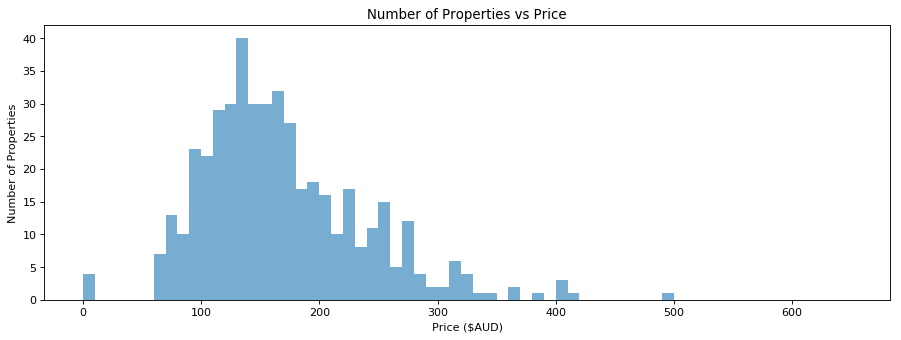

In [16]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=660, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')


# Get the initial price
x = nsw_data['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

print("Total number of properties: " + str(len(x)))

# Plot a histogram of the init_price
ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

Text(0,0.5,'Count')

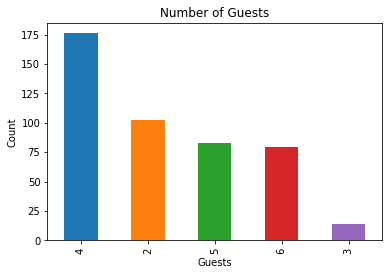

In [17]:
nsw_data['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [18]:
nsw_data['guests'].groupby(nsw_data['guests']).count()

guests
2    102
3     14
4    176
5     83
6     79
Name: guests, dtype: int64

Combined Data set - merge the 4 data files together to get the complete picture.
* nsw_data
* geodata
* cal
* book_sum

In [30]:
# Merge the nsw_extract with the geocoded data: only need the postcode, council, suburb. 
# Convert them to integer values first


full_dataset_1 = nsw_data.merge(geodata_rev, how='left', left_index=True, right_index=True)

full_dataset_2 = full_dataset_1.merge(cal, how='left', left_index=True, right_index=True)

full_dataset_3 = full_dataset_2.merge(book_sum, how='left', left_index=True, right_index=True)

full_dataset_4 = full_dataset_3.merge(feat, how='left', left_index=True, right_index=True)

# Join with property type, keeping property id as the index type
full_dataset_5 = (full_dataset_4.reset_index()
                  .merge(prop_type_table, how='inner', on=['property_type'])
                  .set_index('property_id')
                 )

full_dataset_3.head()


,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,...,url,postcode,council_id,suburb_id,ext_at,features,photos,review_count,review_value,total_booked_days
property_id,,,,,,,,,,,,,,,,,,,,,
806,3,3,5,"[<p><center>, </p>, ELEGANTLY 5 STAR As seen ...",346,8,'T A M B A C' Your Ultimate Beach House Experi...,408,-32.33650,152.54400,...,https://www.stayz.com.au//accommodation/nsw/no...,2428,2.0,2.0,2018-04-12 15:36:09,Air conditioning\nClothes dryer\nCot\nDishwash...,24.0,6.0,4.8,NaN
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.06640,150.67400,...,https://www.stayz.com.au//accommodation/nsw/so...,2540,3.0,3.0,2018-04-12 10:42:30,Air conditioning\nChild's high chair\nClothes ...,22.0,29.0,4.4,2.0
1971,3,6,11,[Ski Cove House is a two storey waterfront on ...,480,15,Ski Cove House with perfect sunsets,357,-32.38740,152.50100,...,https://www.stayz.com.au//accommodation/nsw/no...,2428,2.0,4.0,2018-04-12 09:41:32,Air conditioning\nBalcony\nBooks\nChild's high...,23.0,56.0,4.5,NaN
1971,3,6,11,[Ski Cove House is a two storey waterfront on ...,480,15,Ski Cove House with perfect sunsets,357,-32.38740,152.50100,...,https://www.stayz.com.au//accommodation/nsw/no...,2428,2.0,4.0,2018-04-12 09:41:32,Air conditioning\nBalcony\nBooks\nChild's high...,23.0,56.0,4.5,NaN
2040,2,3,6,[Walking down the driveway that enjoys views t...,270,6,Beaches Mollymook a Beaches&Mntns Girls Getawa...,403,-35.32348,150.48463,...,https://www.stayz.com.au//accommodation/nsw/so...,2539,3.0,5.0,2018-04-12 11:34:19,Air conditioning\nBooks\nClothes dryer\nCoffee...,16.0,NaN,NaN,NaN


In [31]:
# Drop some unnecessary columns
full_dataset_5.drop(columns=['lat', 'lng','syd_brg','scraped_date','property_type','features','url','description_full','heading'],inplace=True)

# Replace any 'NaN' values with zeros
full_dataset_5.fillna(0,inplace=True)

# Sort based on the total booked days for the current 6 month window, sort descending
#full_dataset_6 = full_dataset_5.sort_values(by=['property_id'], ascending=False)

full_dataset = full_dataset_5


# Write out the full dataset

full_dataset.head()

# Can we use a random forest, with the 'total_booked_days' as the result column?

,bathrooms,bedrooms,beds,description_wc,guests,init_price,reviews,syd_brg_deg,syd_dist_km,postcode,...,f_sauna,f_fitness_room_equipment,f_indoor_pool,f_ceiling_fan,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi,f_free_fixed_line_internet,prop_type_id
property_id,,,,,,,,,,,,,,,,,,,,,
806,3,3,5,346,8,408,6,35,223,2428,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1971,3,6,11,480,15,357,56,34,216,2428,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1971,3,6,11,480,15,357,56,34,216,2428,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2040,2,3,6,270,6,403,0,203,161,2539,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2564,3,4,5,352,8,694,27,195,118,2540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
# Write out the full dataset

csv_out = full_dataset.to_csv()

fh = open('/Users/taj/GitHub/scraping/stayz/WebData/nsw_fulldata/stayz_nsw_fulldata_' + date_str + '.csv', 'w')

fh.write(csv_out)

fh.close()

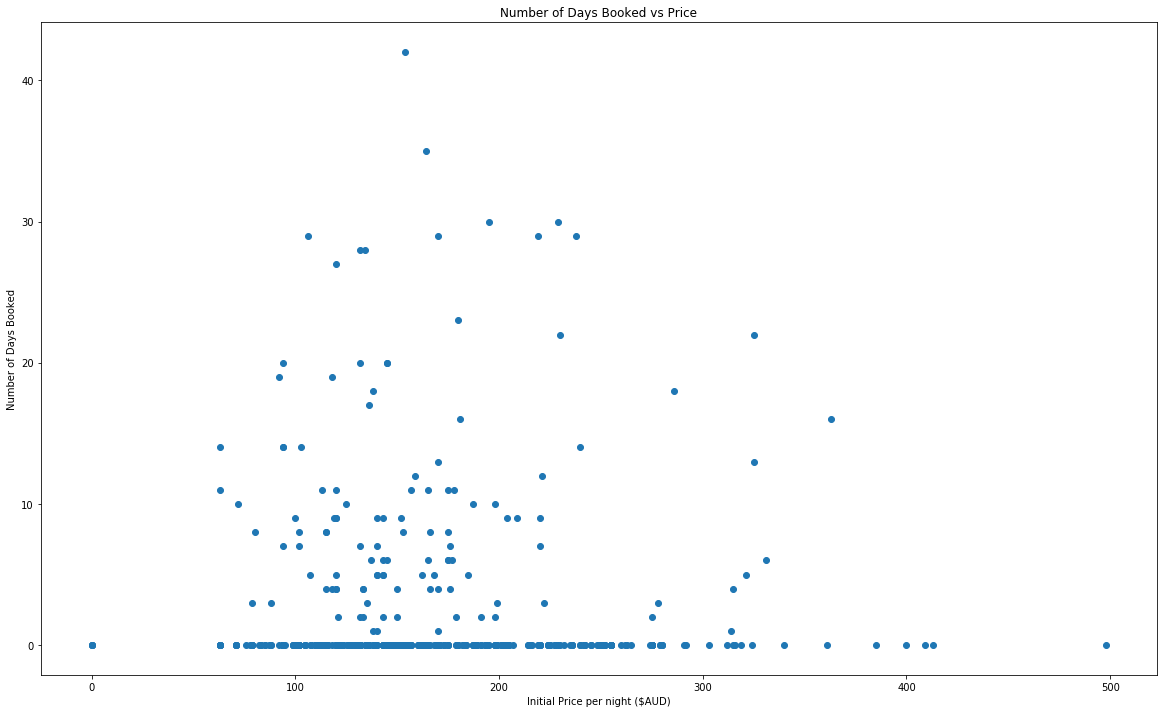

In [22]:
# Plot the bookings vs the initial price
plt.figure(figsize=(20,12))

plt.title('Number of Days Booked vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Number of Days Booked')
plt.scatter(full_dataset['init_price'],full_dataset['total_booked_days'])

plt.show()

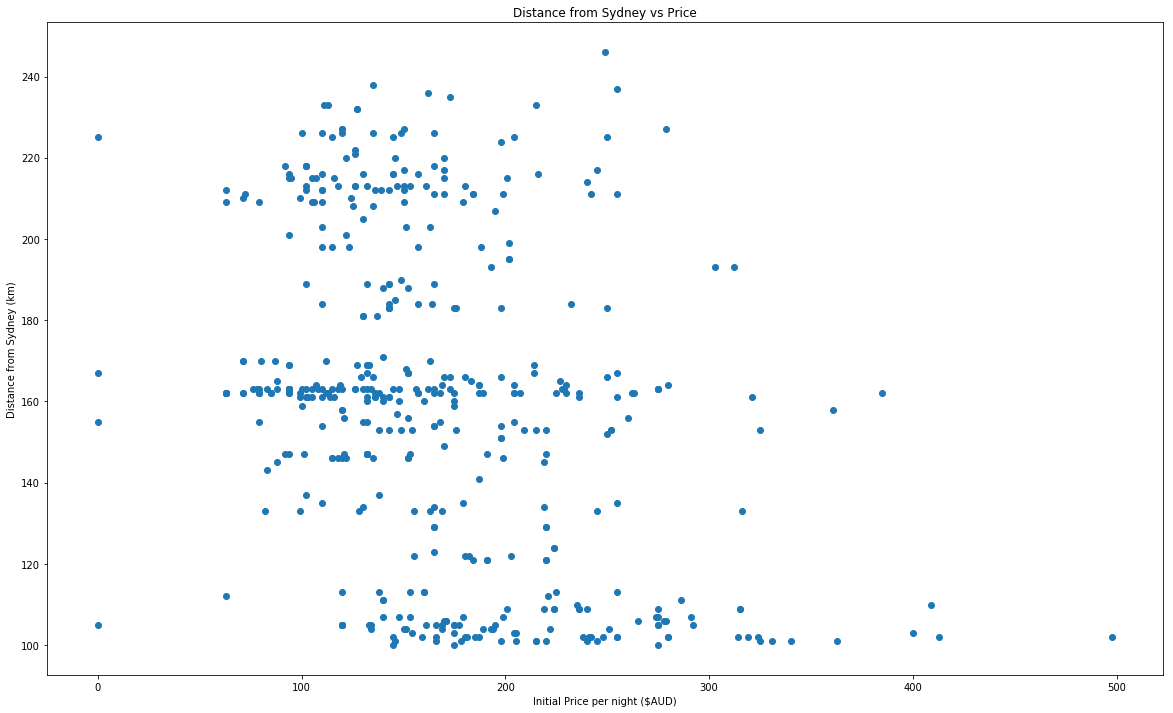

In [23]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))


#nsw_data_s6 = nsw_data_s5[nsw_data_s5['syd_dist_km'] <= 250]

#nsw_data_s7 = nsw_data_s6[nsw_data_s6['init_price'] <= 600]

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(full_dataset['init_price'],full_dataset['syd_dist_km'])

plt.show()

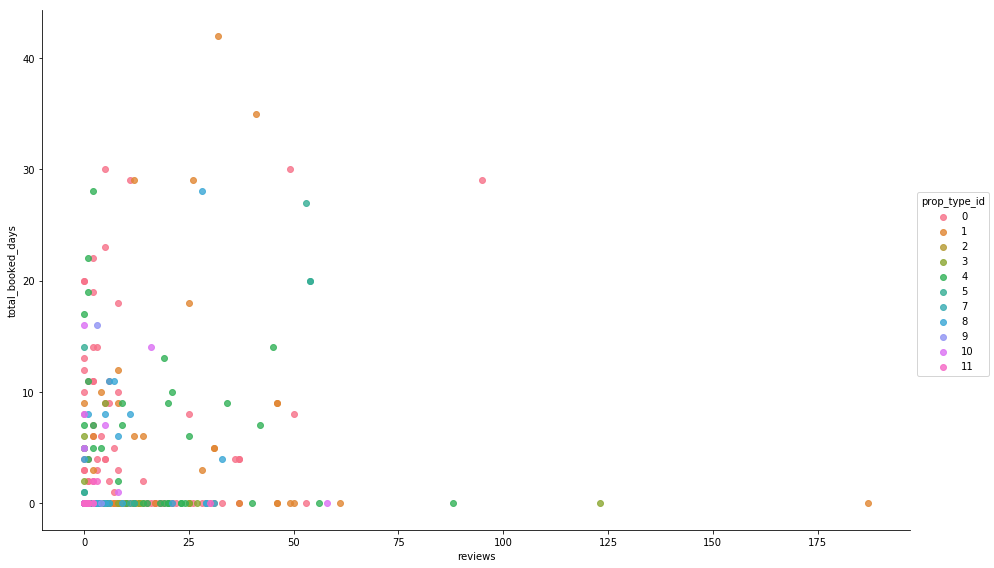

In [24]:
# Now check individual graphs in detail
sns.lmplot( x="reviews", y="total_booked_days", data=full_dataset, fit_reg=False
           , hue='prop_type_id'
           , aspect=1.61
          , size=8)


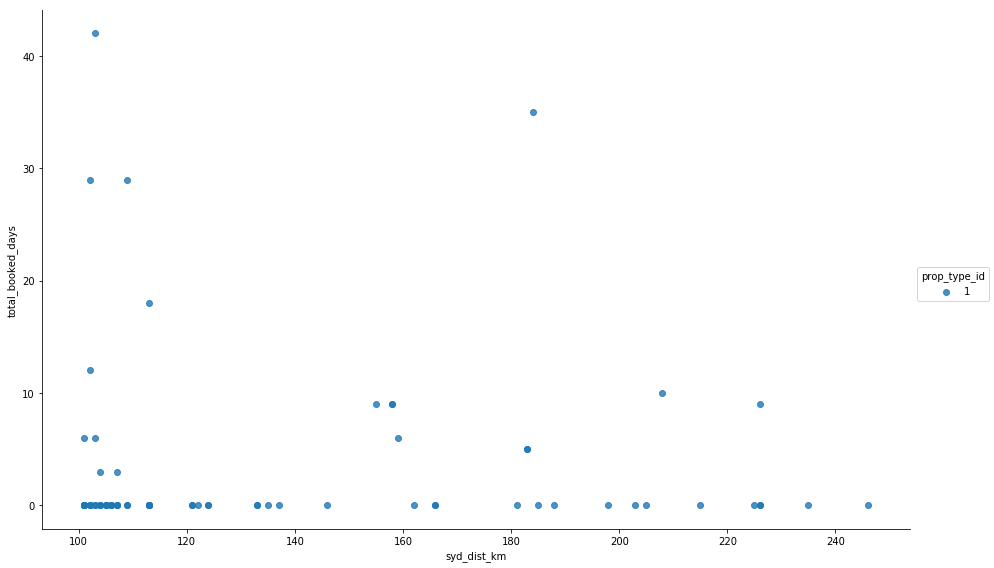

In [25]:
# Now check individual graphs in detail

# Try just one property_type - House

nsw_data_s8 = full_dataset[full_dataset['prop_type_id'] == 1]

sns.lmplot( x="syd_dist_km", y="total_booked_days", data=nsw_data_s8, fit_reg=False
           , hue='prop_type_id'
           , aspect=1.61
          , size=8)

In [26]:
test_cor = full_dataset.corr(method='pearson')

test_cor

,bathrooms,bedrooms,beds,description_wc,guests,init_price,reviews,syd_brg_deg,syd_dist_km,council_id,...,f_sauna,f_fitness_room_equipment,f_indoor_pool,f_ceiling_fan,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi,f_free_fixed_line_internet,prop_type_id
bathrooms,1.000000,0.246651,0.143645,0.111745,0.119708,0.180851,0.016640,0.019073,0.005763,-0.050127,...,-0.019038,NaN,-0.046887,0.011154,0.078058,-0.004507,0.034771,NaN,NaN,-0.042782
bedrooms,0.246651,1.000000,0.652360,-0.101953,0.746208,-0.020539,-0.036786,-0.229673,0.144292,-0.123030,...,-0.073379,NaN,-0.012120,0.040483,0.068570,-0.000119,-0.026219,NaN,NaN,-0.204539
beds,0.143645,0.652360,1.000000,-0.058390,0.744169,-0.104999,-0.018930,-0.160858,0.118718,-0.074585,...,0.103009,NaN,-0.019729,0.152054,0.064629,0.074930,-0.032718,NaN,NaN,-0.152384
description_wc,0.111745,-0.101953,-0.058390,1.000000,-0.072125,0.156802,0.213812,0.062501,-0.068846,-0.042193,...,-0.010478,NaN,0.036666,-0.041715,-0.044591,-0.055904,0.002988,NaN,NaN,0.105770
guests,0.119708,0.746208,0.744169,-0.072125,1.000000,-0.135907,0.003506,-0.239969,0.133752,-0.118218,...,0.032300,NaN,-0.064467,0.116401,0.026083,0.065516,-0.045437,NaN,NaN,-0.140285
init_price,0.180851,-0.020539,-0.104999,0.156802,-0.135907,1.000000,0.044217,0.200614,-0.354345,-0.170125,...,0.050556,NaN,0.047634,-0.013798,0.195661,0.079354,0.074674,NaN,NaN,-0.101801
reviews,0.016640,-0.036786,-0.018930,0.213812,0.003506,0.044217,1.000000,0.057965,-0.084165,-0.049941,...,0.021332,NaN,0.084864,-0.045821,-0.068232,0.010044,0.053781,NaN,NaN,-0.039473
syd_brg_deg,0.019073,-0.229673,-0.160858,0.062501,-0.239969,0.200614,0.057965,1.000000,-0.430755,0.436939,...,0.007682,NaN,0.047217,-0.043986,0.048998,0.072282,0.067236,NaN,NaN,-0.032927
syd_dist_km,0.005763,0.144292,0.118718,-0.068846,0.133752,-0.354345,-0.084165,-0.430755,1.000000,0.361337,...,-0.059558,NaN,-0.077982,-0.012085,-0.051051,-0.079379,-0.051333,NaN,NaN,-0.039148
council_id,-0.050127,-0.123030,-0.074585,-0.042193,-0.118218,-0.170125,-0.049941,0.436939,0.361337,1.000000,...,-0.017359,NaN,-0.021289,-0.010222,0.060706,-0.008348,0.012984,NaN,NaN,-0.029153


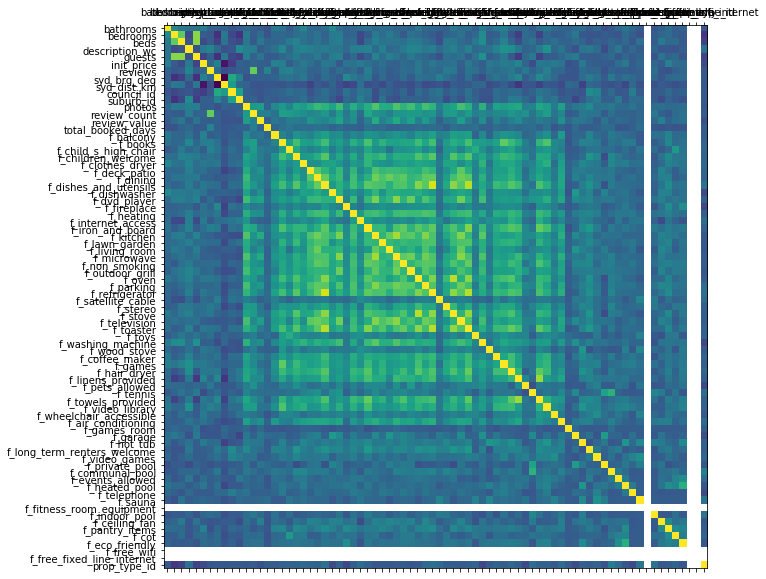

In [27]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(full_dataset)